In [66]:
import torch 
import numpy as np
import pandas as pd 
from utilities import *
from math import ceil
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
from torch.autograd import Variable

In [67]:
big_df = pd.read_csv('Datasets/sp500_sentiment_non_weighted.csv')
big_df

,Unnamed: 0,date,Volume,Close,Positive,Negative,Neutral,Price_change
0,0,2010-01-05,1.111477e+07,1136.520020,0.157785,0.489590,0.352625,1
1,1,2010-01-06,9.592200e+06,1137.140015,0.159253,0.114102,0.726645,1
2,2,2010-01-07,1.264640e+07,1141.689941,0.441000,0.012006,0.546994,1
3,3,2010-01-08,1.508503e+07,1144.979980,0.039152,0.384472,0.576376,1
4,4,2010-01-11,7.396000e+06,1146.979980,0.114053,0.029774,0.856173,1
...,...,...,...,...,...,...,...,...
2603,2603,2020-06-05,2.503270e+07,3193.929932,0.567891,0.070503,0.361606,1
2604,2604,2020-06-08,2.303770e+07,3232.389893,0.523481,0.124646,0.351873,1
2605,2605,2020-06-09,2.969893e+07,3207.179932,0.296441,0.337487,0.366072,-1
2606,2606,2020-06-10,3.795272e+07,3190.139893,0.390972,0.240399,0.368628,-1


### Pre-process dataset
Create a time series dataset, features consist of the previous day's close price while today's close price is the label.

In [68]:
seq_len = 1
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((big_df.shape[0] - seq_len, 4))
y = np.zeros((big_df.shape[0] - seq_len, 1))
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (2607, 4)
y shape : (2607, 1)


In [69]:
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous day close price as feature 
    X[i-seq_len] = prev_elems
    # Store "today's" close price as label
    y[i-seq_len] = big_df.iloc[i]['Close']

### Normalise dataset and split into train-test.
Min - Max scaling 

In [70]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()

X_mm = mm.fit_transform(X)
y_mm = mm.fit_transform(np.array(y).reshape(-1, 1))

Data splitting into train,val, test . 

In [71]:
# fraction of the test set.
percentage = 0.3
split_tr = ceil(X_mm.shape[0] *(1-percentage))
split_val = ceil(X_mm.shape[0] *(1- percentage/2))

X_train = X_mm[0:split_tr]
y_train = y_mm[0:split_tr]
X_val= X_mm[split_tr: split_val]
y_val= y_mm[split_tr: split_val]
X_test= X_mm[split_val:]
y_test= y_mm[split_val:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Test data shapes X:{X_test.shape} , y:{y_test.shape}")
print(f"Val data shapes X:{X_val.shape} , y:{y_val.shape}")

Train data shapes X:(1825, 4) , y:(1825, 1)
Test data shapes X:(391, 4) , y:(391, 1)
Val data shapes X:(391, 4) , y:(391, 1)


### Convert np.arrays into tensors and reshape in the format expected by the LSTM .

In [72]:
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y_mm))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))


In [73]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
X_val_tensors = Variable(torch.Tensor(X_val))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
y_val_tensors = Variable(torch.Tensor(y_val))

In [74]:
#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
X_val_tensors_final = torch.reshape(X_val_tensors,  (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)
print("Testing Shape", X_val_tensors_final.shape, y_val_tensors.shape)

Training Shape torch.Size([1825, 1, 4]) torch.Size([1825, 1])
Testing Shape torch.Size([391, 1, 4]) torch.Size([391, 1])
Testing Shape torch.Size([391, 1, 4]) torch.Size([391, 1])


### Define LSTM structure .
The LSTM will execute regression, so MSE loss is need during training. 

In [75]:
class LSTM_reg(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout=0.3, fc_size = 128):
        super(LSTM_reg, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size * num_layers, fc_size) #fully connected 1
        self.fc = nn.Linear(fc_size, num_classes) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state 1st lstm layer
        c_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state 1st lstm layer

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0_0, c_0_0)) #lstm with input, hidden, and internal state
       # print(output.shape)
       # print(hn.shape)
        hn = hn.view(-1, self.hidden_size * num_layers) #reshaping (flatten) the data for Dense layer next
       # print(hn.shape)
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output

        return out

In [94]:
#hyperparameters
num_epochs = 1500 #1000 epochs
learning_rate = 0.0003 #0.001 lr

input_size = 4 #number of features
hidden_size = 60 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

lstm_reg = LSTM_reg(num_classes, input_size, hidden_size, num_layers, dropout=0.3, fc_size=310) #our lstm class

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_reg.parameters(), lr=learning_rate)

C:\Users\Konpoul\miniconda3\envs\data-an\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


#### Training loop

In [95]:
plot_loss_tr = []
plot_loss_val = []
for epoch in tqdm(range(num_epochs)):
    outputs = lstm_reg.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    plot_loss_tr.append(loss.item())
    loss.backward() #calculates the loss of the loss function

    # Compute validation loss
    val_outs = lstm_reg.forward(X_val_tensors_final) #forward pass
    val_loss = criterion(val_outs, y_val_tensors)
    plot_loss_val.append(val_loss.item())

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, train_loss: %1.5f,  val_loss: %1.5f " % (epoch, loss.item(), val_loss.item()))

  1%|▌                                                                               | 10/1500 [00:00<00:32, 45.85it/s]

Epoch: 0, train_loss: 0.07212,  val_loss: 0.39101 


  7%|█████▋                                                                         | 107/1500 [00:01<00:24, 57.15it/s]

Epoch: 100, train_loss: 0.02251,  val_loss: 0.14201 


 14%|██████████▉                                                                    | 208/1500 [00:03<00:24, 52.31it/s]

Epoch: 200, train_loss: 0.00942,  val_loss: 0.06041 


 21%|████████████████▎                                                              | 310/1500 [00:05<00:21, 55.69it/s]

Epoch: 300, train_loss: 0.00008,  val_loss: 0.00114 


 27%|█████████████████████▍                                                         | 406/1500 [00:07<00:21, 51.41it/s]

Epoch: 400, train_loss: 0.00004,  val_loss: 0.00048 


 34%|██████████████████████████▊                                                    | 508/1500 [00:09<00:17, 56.57it/s]

Epoch: 500, train_loss: 0.00004,  val_loss: 0.00047 


 41%|████████████████████████████████▏                                              | 610/1500 [00:11<00:15, 55.71it/s]

Epoch: 600, train_loss: 0.00004,  val_loss: 0.00046 


 47%|█████████████████████████████████████▏                                         | 706/1500 [00:13<00:14, 53.51it/s]

Epoch: 700, train_loss: 0.00004,  val_loss: 0.00046 


 54%|██████████████████████████████████████████▌                                    | 808/1500 [00:15<00:12, 55.04it/s]

Epoch: 800, train_loss: 0.00004,  val_loss: 0.00045 


 61%|███████████████████████████████████████████████▉                               | 910/1500 [00:16<00:10, 55.79it/s]

Epoch: 900, train_loss: 0.00004,  val_loss: 0.00045 


 67%|████████████████████████████████████████████████████▎                         | 1006/1500 [00:18<00:09, 54.30it/s]

Epoch: 1000, train_loss: 0.00004,  val_loss: 0.00045 


 74%|█████████████████████████████████████████████████████████▌                    | 1106/1500 [00:20<00:08, 47.11it/s]

Epoch: 1100, train_loss: 0.00004,  val_loss: 0.00045 


 81%|██████████████████████████████████████████████████████████████▉               | 1211/1500 [00:22<00:05, 56.01it/s]

Epoch: 1200, train_loss: 0.00004,  val_loss: 0.00045 


 87%|████████████████████████████████████████████████████████████████████          | 1308/1500 [00:24<00:03, 56.96it/s]

Epoch: 1300, train_loss: 0.00004,  val_loss: 0.00045 


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1411/1500 [00:26<00:01, 54.75it/s]

Epoch: 1400, train_loss: 0.00004,  val_loss: 0.00046 


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:28<00:00, 53.22it/s]


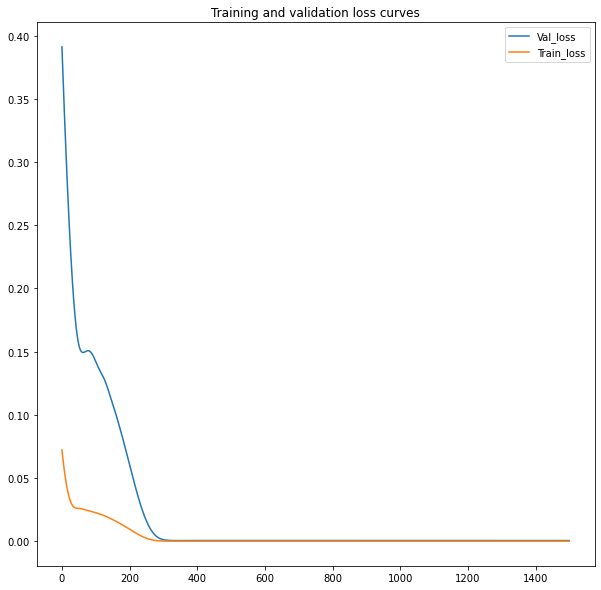

In [96]:
fig , ax = plt.subplots(figsize = (10,10))

plt.plot(plot_loss_val, label='Val_loss') #actual plot
plt.plot(plot_loss_tr, label='Train_loss') #predicted plot
plt.title('Training and validation loss curves')
plt.legend()
plt.show()

### Predicting with the LSTM

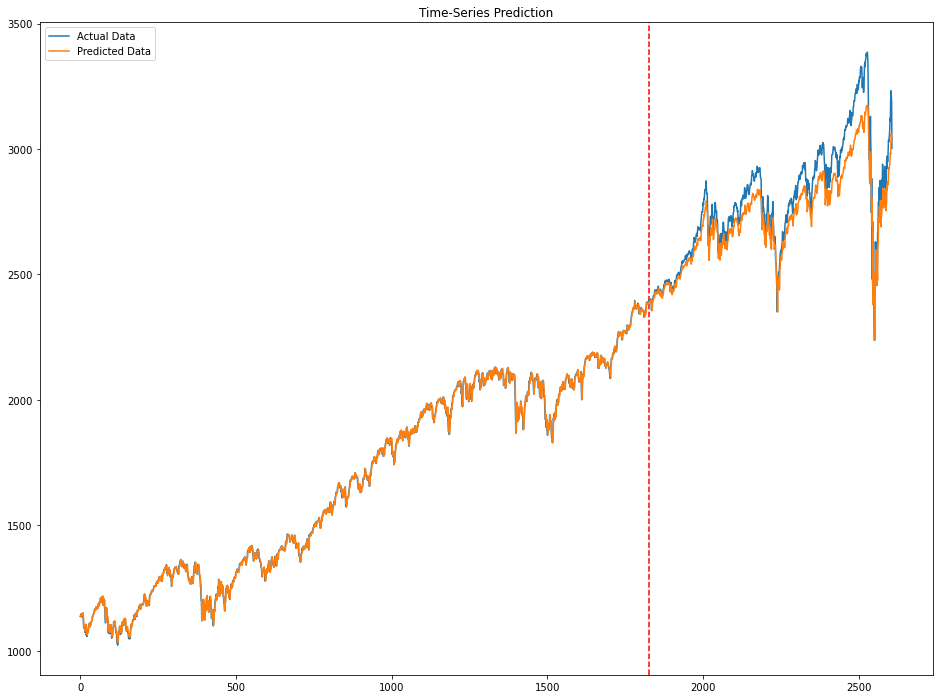

In [97]:
train_predict = lstm_reg(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_tensors.data.numpy()
dataY_plot =  np.reshape(dataY_plot, (dataY_plot.shape[0],1))

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(16,12)) #plotting
plt.axvline(x=split_tr, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### Evaluation of regression predictions with MSE and Spearman Correlation. 

In [98]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[split_tr : split_val] - data_predict[split_tr : split_val], 2).mean())
print("VAL DATA, MSE loss : ", mse)

VAL DATA, MSE loss :  2568.1313


In [99]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[:split_tr] - data_predict[:split_tr], 2).mean())
print("TRAIN DATA , MSE loss : ", mse)

TRAIN DATA , MSE loss :  221.69812


In [100]:
from scipy.stats import spearmanr, pearsonr
#from sklearn.metric import mean_squared_error
spearman = spearmanr(dataY_plot[split_tr : split_val], data_predict[split_tr : split_val])
print("Val DATA,  Spreaman correlation : ", spearman)
pearson, p= pearsonr(np.squeeze(dataY_plot[split_tr : split_val]), np.squeeze(data_predict[split_tr : split_val]))
print("VAL DATA,  Pearson correlation=", pearson, ", pvalue=",p)


#from sklearn.metric import mean_squared_error
spearman = spearmanr(dataY_plot[:split_tr],data_predict[:split_tr])
print("TRAIN DATA , Spreaman correlation : ", spearman)
pearson2, p2= pearsonr(np.squeeze(dataY_plot[:split_tr]), np.squeeze(data_predict[:split_tr]))
print("TRAIN DATA,  Pearson correlation=", pearson2, ", pvalue=",p2)

Val DATA,  Spreaman correlation :  SpearmanrResult(correlation=0.98654106992708, pvalue=4.842425814240695e-308)
VAL DATA,  Pearson correlation= 0.9904494411572686 , pvalue= 0.0
TRAIN DATA , Spreaman correlation :  SpearmanrResult(correlation=0.9982301670008928, pvalue=0.0)
TRAIN DATA,  Pearson correlation= 0.9992699021578725 , pvalue= 0.0


#### Test dataset evaluation (Run only once at the end)

In [101]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[split_val:] - data_predict[split_val:], 2).mean())
print("TEST DATA, MSE loss : ", mse)

spearman = spearmanr(dataY_plot[split_val:],data_predict[split_val:])
print("TEST DATA,  Spreaman correlation : ", spearman)
pearson, p= pearsonr(np.squeeze(dataY_plot[split_val : ]), np.squeeze(data_predict[split_val : ]))
print("TEST DATA,  Pearson correlation=", pearson, ", pvalue=",p)

TEST DATA, MSE loss :  12520.647
TEST DATA,  Spreaman correlation :  SpearmanrResult(correlation=0.9789322240066052, pvalue=1.6426113962763768e-270)
TEST DATA,  Pearson correlation= 0.9727042089130904 , pvalue= 6.742274044972279e-249


# 2.) Classification of price movement with LSTM 

## Pre-process dataset


### Price_change is the class . 0: decrease , +1 : increase

Normalise the Close price column and convert Price_change column to (0,1) instead of (-1, 1). 

In [102]:
big_df['Price_change'] = big_df['Price_change'].apply(lambda x : x+1 if (x==-1) else x)
big_df['Close'] = (big_df['Close']-big_df['Close'].min())/(big_df['Close'].max()-big_df['Close'].min())
big_df

,Unnamed: 0,date,Volume,Close,Positive,Negative,Neutral,Price_change
0,0,2010-01-05,1.111477e+07,0.048207,0.157785,0.489590,0.352625,1
1,1,2010-01-06,9.592200e+06,0.048469,0.159253,0.114102,0.726645,1
2,2,2010-01-07,1.264640e+07,0.050394,0.441000,0.012006,0.546994,1
3,3,2010-01-08,1.508503e+07,0.051786,0.039152,0.384472,0.576376,1
4,4,2010-01-11,7.396000e+06,0.052632,0.114053,0.029774,0.856173,1
...,...,...,...,...,...,...,...,...
2603,2603,2020-06-05,2.503270e+07,0.918674,0.567891,0.070503,0.361606,1
2604,2604,2020-06-08,2.303770e+07,0.934946,0.523481,0.124646,0.351873,1
2605,2605,2020-06-09,2.969893e+07,0.924280,0.296441,0.337487,0.366072,0
2606,2606,2020-06-10,3.795272e+07,0.917070,0.390972,0.240399,0.368628,0


In [103]:
seq_len = 1
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((big_df.shape[0] - seq_len, 4))
y = np.zeros((big_df.shape[0] - seq_len, 2))
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (2607, 4)
y shape : (2607, 2)


#### Sparse vector format labels.

In [104]:
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous 30 days close price
    X[i-seq_len] = prev_elems
   # y[i-seq_len]  = big_df.iloc[i]['Price_change']
    # Store label, close price of day 31 
    change = big_df.iloc[i]['Price_change']
    if change==0 : # decrease
        y[i-seq_len] = np.array([0, 1]) # vector for decrease
    else : 
        y[i-seq_len] = np.array([1, 0]) # vector for increase

#### Binary format labels

In [105]:
'''
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous 30 days close price
    X[i-seq_len] = prev_elems
    y[i-seq_len]  = big_df.iloc[i]['Price_change']
'''

"\nfor i in range(seq_len , X.shape[0] + seq_len) :\n    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date\n    # only the desired values\n    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]\n    prev_elems = np.array(prev_elems)\n    # Store previous 30 days close price\n    X[i-seq_len] = prev_elems\n    y[i-seq_len]  = big_df.iloc[i]['Price_change']\n"

### Normalise dataset and split into train-test.
#### Convert np.arrays into tensors and reshape in the format expected by the LSTM .
Min - Max scaling 

In [106]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()
#X_price_norm = mm.fit_transform(X[:,0])
X_mm = X # mm.fit_transform(X)

# fraction of the test set.
percentage = 0.4
split_tr = ceil(X_mm.shape[0] *(1-percentage))
split_val = ceil(X_mm.shape[0] *(1- percentage/2))

X_train = X_mm[0:split_tr]
y_train = y[0:split_tr]
X_val= X_mm[split_tr: split_val]
y_val= y[split_tr: split_val]
X_test= X_mm[split_val:]
y_test= y[split_val:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Test data shapes X:{X_test.shape} , y:{y_test.shape}")
print(f"Val data shapes X:{X_val.shape} , y:{y_val.shape}")

### TO tensors 
###
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
X_val_tensors = Variable(torch.Tensor(X_val))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
y_val_tensors = Variable(torch.Tensor(y_val))

#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
X_val_tensors_final = torch.reshape(X_val_tensors,  (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)
print("Validation Shape", X_val_tensors_final.shape, y_val_tensors.shape)

Train data shapes X:(1565, 4) , y:(1565, 2)
Test data shapes X:(521, 4) , y:(521, 2)
Val data shapes X:(521, 4) , y:(521, 2)
Training Shape torch.Size([1565, 1, 4]) torch.Size([1565, 2])
Testing Shape torch.Size([521, 1, 4]) torch.Size([521, 2])
Validation Shape torch.Size([521, 1, 4]) torch.Size([521, 2])


### Define classification LSTM  : We need to add a sigmoid activation function at the end in order to get output in the $[0,1]$ range.

In [107]:
class LSTM_clf(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout=0.3, fc_size = 128):
        super(LSTM_clf, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size * num_layers, fc_size) #fully connected 1
        self.fc = nn.Linear(fc_size, num_classes) #fully connected last layer
        self.dropout = nn.Dropout(p=dropout)

        self.relu = nn.ReLU()
        # sigmoid activation for end classification
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self,x):
        h_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state 1st lstm layer
        c_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state 1st lstm layer

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0_0, c_0_0)) #lstm with input, hidden, and internal state
       # print(output.shape)
       # print(hn.shape)
        hn = hn.view(-1, self.hidden_size * num_layers) #reshaping (flatten) the data for Dense layer next
       # print(hn.shape)
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.dropout(out)
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        
        out = self.sigm(out)
        return out

#### Training the LSTM . 

In [124]:
#hyperparameters
num_epochs = 800 #1000 epochs
learning_rate = 0.0001
input_size = 4 #number of features
hidden_size = 60 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes

lstm_clf = LSTM_clf(num_classes, input_size, hidden_size, num_layers, dropout = 0.3, fc_size=128)#X_train_tensors_final.shape[1]) #our lstm class

criterion = torch.nn.BCELoss() #   # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_clf.parameters(), lr=learning_rate)


plot_loss_tr = []
plot_loss_val = []
for epoch in tqdm(range(num_epochs)):
    
    #print(X_train_tensors_final.shape)
    outputs = lstm_clf.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    #print(outputs.shape)
    #print(y_train_tensors.shape)
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    plot_loss_tr.append(loss.item())
    loss.backward() #calculates the loss of the loss function

    # Compute validation loss
    val_outs = lstm_clf.forward(X_val_tensors_final) #forward pass
    val_loss = criterion(val_outs, y_val_tensors)
    plot_loss_val.append(val_loss.item())
    
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, train_loss: %1.5f,  val_loss: %1.5f " % (epoch, loss.item(), val_loss.item()))

C:\Users\Konpoul\miniconda3\envs\data-an\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|▋                                                                                 | 7/800 [00:00<00:12, 63.46it/s]

Epoch: 0, train_loss: 0.69162,  val_loss: 0.69132 


 14%|███████████▏                                                                    | 112/800 [00:01<00:10, 64.14it/s]

Epoch: 100, train_loss: 0.68987,  val_loss: 0.68935 


 26%|█████████████████████▏                                                          | 212/800 [00:03<00:08, 66.51it/s]

Epoch: 200, train_loss: 0.68965,  val_loss: 0.68808 


 39%|███████████████████████████████▏                                                | 312/800 [00:04<00:07, 62.81it/s]

Epoch: 300, train_loss: 0.68906,  val_loss: 0.68803 


 51%|█████████████████████████████████████████                                       | 411/800 [00:06<00:06, 64.38it/s]

Epoch: 400, train_loss: 0.68922,  val_loss: 0.68743 


 64%|███████████████████████████████████████████████████                             | 511/800 [00:07<00:04, 67.26it/s]

Epoch: 500, train_loss: 0.68793,  val_loss: 0.68801 


 76%|████████████████████████████████████████████████████████████▊                   | 608/800 [00:09<00:02, 69.72it/s]

Epoch: 600, train_loss: 0.68770,  val_loss: 0.68800 


 89%|██████████████████████████████████████████████████████████████████████▉         | 709/800 [00:10<00:01, 69.15it/s]

Epoch: 700, train_loss: 0.68737,  val_loss: 0.68802 


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:12<00:00, 65.52it/s]


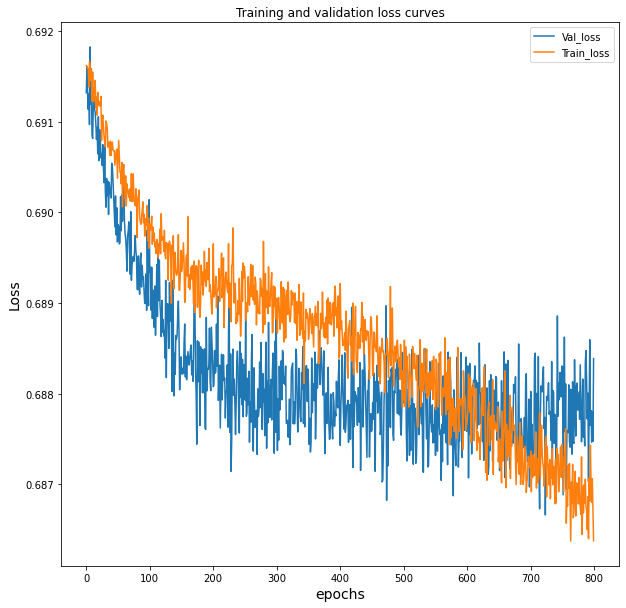

In [125]:
fig , ax = plt.subplots(figsize = (10,10))

plt.plot(plot_loss_val, label='Val_loss') #actual plot
plt.plot(plot_loss_tr, label='Train_loss') #predicted plot
plt.title('Training and validation loss curves')
plt.xlabel('epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.show()

### Prediction and evaluation of LSTM classifier .

 predictions in the right form to be accepted by sklearn accuracy functions and confusion matrix

In [126]:
train_predict = lstm_clf(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
for i in range(len(data_predict)):
    index = np.argmax(data_predict, axis=1) # np.where(data_predict >=0.5, 1, 0) #
    if (index[i] == 0) :
        data_predict[i][index] = 1
        data_predict[i][1] = 0 
    else :
        data_predict[i][0] = 0
        data_predict[i][1] = 1 

In [127]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#from sklearn.metric import mean_squared_error
acc = accuracy_score(y[:split_tr], data_predict[:split_tr])
print("TRAIN DATA , accuracy : ", round(acc,6))

#bacc =  balanced_accuracy_score(y[:split_tr], predictions[:split_tr])
#print("TRAIN DATA , balanced accuracy : ", round(bacc,6))

acc = accuracy_score(y[split_tr : split_val], data_predict[split_tr : split_val])
print("VAL DATA, accuracy : ", round(acc,6))

TRAIN DATA , accuracy :  0.552716
VAL DATA, accuracy :  0.552783


In [128]:
# Number of increase predictions 
print("Number of increase label predictions :",data_predict[data_predict[:,0] == 1].shape)
print("Number of decrease label predictions :",data_predict[data_predict[:,1] == 1].shape)
print("Overall data dataset shape : ",data_predict.shape)

Number of increase label predictions : (2440, 2)
Number of decrease label predictions : (167, 2)
Overall data dataset shape :  (2607, 2)


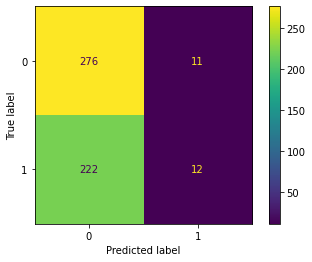

In [129]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_conf = np.argmax(y, axis=1)
pred_conf = np.argmax(data_predict, axis=1)

cm = confusion_matrix(y_conf[split_tr : split_val] , pred_conf[split_tr : split_val], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

#### TEST EVALUATION

TEST DATA, accuracy :  0.541267


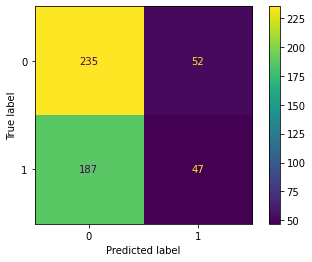

In [130]:
acc = accuracy_score(y_conf[split_val:], pred_conf[split_val:])
print("TEST DATA, accuracy : ", round(acc,6))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_conf[split_val:] , pred_conf[split_val:], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                         display_labels=[0,1])
disp.plot()
plt.show()